In [7]:
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
from networks.vae import ConvVAE, vae_loss

In [9]:
all_data = []

for i in range(8):
    batch_data = np.load(f'data/train_observations_batch_{i}.npy')
    reshaped_data = batch_data[:, 0, :, :, :, :]
    reshaped_data = reshaped_data.reshape(-1, 3, 64, 64)
    all_data.append(reshaped_data)

data = np.concatenate(all_data, axis=0)

In [10]:
data_tensor = torch.tensor(data, dtype=torch.float32)

batch_size = 32
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
def train_vae(model, data_loader, optimizer, device, n_epochs, save_path):
    model = model.to(device)

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        for data in tqdm(data_loader):
            train_data = data[0].to(device)
            optimizer.zero_grad()
            x_reconstr, mu, logvar = model(train_data)
            loss = vae_loss(x_reconstr, train_data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(data_loader)
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_train_loss:.4f}')

    if save_path is not None:
        torch.save(model.state_dict(), save_path)
        print(f'Trained model saved to {save_path}')

In [12]:
n_channels = 3
latent_dim = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = ConvVAE(n_channels, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

n_epochs = 10
save_path = f'saved_models/vae/vae_model_{latent_dim}.pth'
train_vae(vae, data_loader, optimizer, device, n_epochs, save_path)

100%|██████████| 512/512 [00:05<00:00, 89.08it/s] 


Epoch [1/10], Loss: 251507.5944


100%|██████████| 512/512 [00:04<00:00, 116.42it/s]


Epoch [2/10], Loss: 250016.6121


100%|██████████| 512/512 [00:04<00:00, 114.37it/s]


Epoch [3/10], Loss: 249747.5860


100%|██████████| 512/512 [00:04<00:00, 110.10it/s]


Epoch [4/10], Loss: 249629.5955


100%|██████████| 512/512 [00:04<00:00, 106.70it/s]


Epoch [5/10], Loss: 249507.0813


100%|██████████| 512/512 [00:05<00:00, 98.75it/s]


Epoch [6/10], Loss: 249435.3449


100%|██████████| 512/512 [00:04<00:00, 111.57it/s]


Epoch [7/10], Loss: 249398.8237


100%|██████████| 512/512 [00:04<00:00, 108.71it/s]


Epoch [8/10], Loss: 249366.2383


100%|██████████| 512/512 [00:04<00:00, 113.46it/s]


Epoch [9/10], Loss: 249335.9059


100%|██████████| 512/512 [00:04<00:00, 112.95it/s]

Epoch [10/10], Loss: 249336.5936
Trained model saved to saved_models/vae/vae_model_32.pth


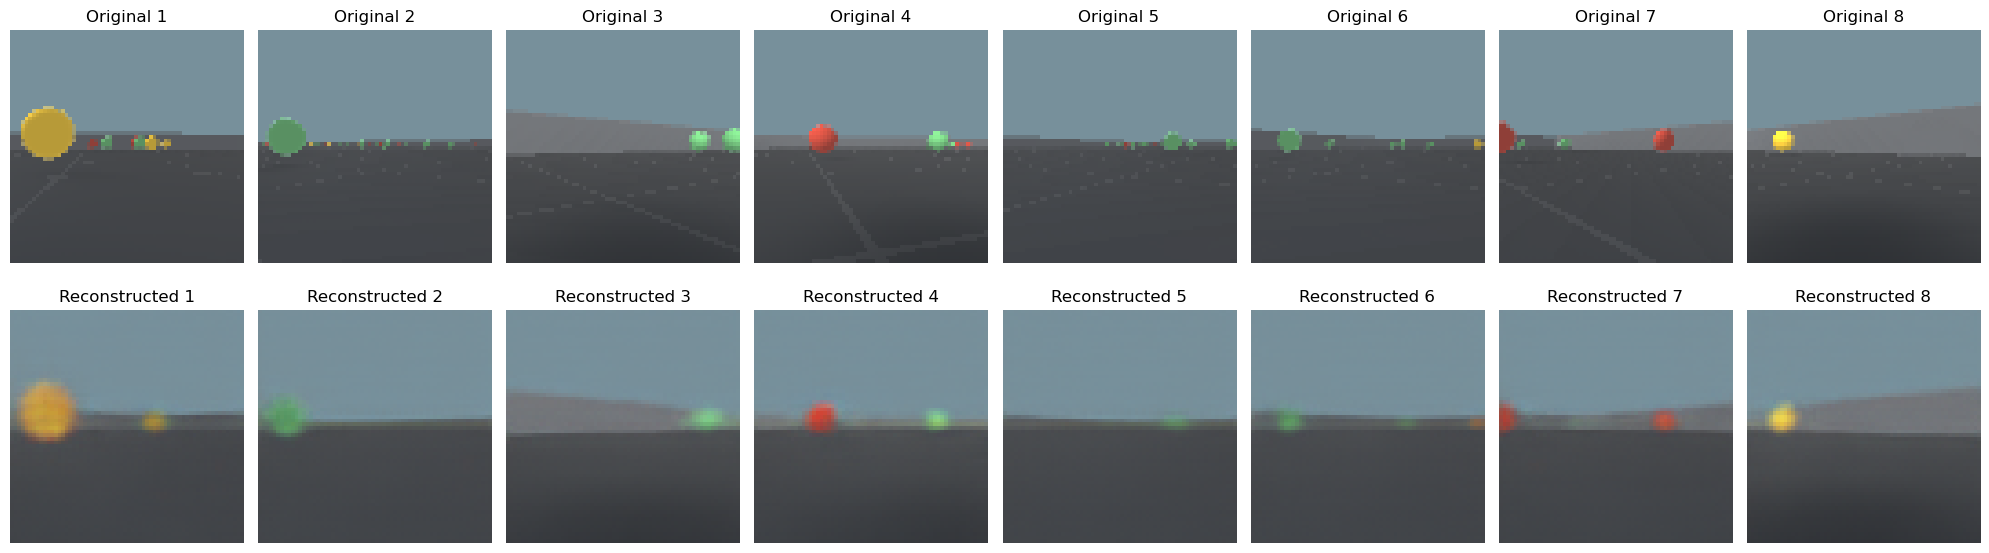

In [16]:
random_indices = np.random.choice(data.shape[0], 8, replace=False)
random_images = data[random_indices]

random_images_tensor = torch.tensor(random_images, dtype=torch.float32).to(device)

vae.eval()
with torch.no_grad():
    reconstructions, _, _ = vae(random_images_tensor)

reconstructions = reconstructions.cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(20, 6))

for i in range(8):
    # Original images
    axes[0, i].imshow(random_images[i].transpose(1, 2, 0))
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')

    # Reconstructed images
    axes[1, i].imshow(reconstructions[i].transpose(1, 2, 0))
    axes[1, i].set_title(f'Reconstructed {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()